In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optimizer
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [2]:
import scipy.io
from collections import defaultdict
import pandas as pd
import os, sys
from torchvision import transforms 
import random
import glob
import xml.etree.ElementTree as ET
import cv2
%matplotlib inline

In [3]:
image_bbox = {"jpg":"xml"}
base = "../../Data/vegi_with_bbox"
xsize, ysize = (224, 224) #for VGG16 model. set it as required by model
target_map = {''} 
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
image_map = {'cucumber': 0, 'eggplant': 1, 'mushroom': 2}
index_image = {0:'cucumber', 1:'eggplant', 2:'mushroom'}
random.seed(40)

**image transformation code copied and modified from**
[aakanksha](https://jovian.ml/aakanksha-ns/road-signs-bounding-box-prediction)

In [4]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=0):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def create_bb(bb, color='red'):
    bb = np.array(bb, dtype=np.int)
    return plt.Rectangle((bb[0], bb[1]), bb[2]-bb[0], bb[3]-bb[1], color=color,
                         fill=False, lw=3)

def show_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_bb(bb))

def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = [int(item) for item in bb]
    Y[bb[1]:bb[3], bb[0]:bb[2]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return [top_row, left_col, bottom_row, right_col] 

def resize_image_bb(read_path,write_path,bb,sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=5):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms=False, szx=None, szy=None):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        
        rdeg = (np.random.random()-.50)*10 + np.random.choice([0,90,180,270])
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    if szx != None and szy != None:    
        x = cv2.resize(x, (szx, szy))
        Y = cv2.resize(Y, (szx, szy))    
    return x, mask_to_bb(Y)

def normalize(im):
    return (im/255. - MEAN)/STD

def unnormalize(im):
    return (im*STD + MEAN)*255.

def normalize_bbox(bb):
    xs = float(xsize)
    ys = float(ysize)
    return [bb[0]/xs, bb[1]/ys, bb[2]/xs, bb[3]/ys]

def unnormalize_bbox(bb):
    xs = float(xsize)
    ys = float(ysize)
    return [int(bb[0]*xs), int(bb[1]*ys), int(bb[2]*xs), int(bb[3]*ys)]

**XML extraction**

In [5]:
def read_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()
    cat = root.find("object/name").text
    xmin = root.find("object/bndbox/xmin").text
    ymin = root.find("object/bndbox/ymin").text
    xmax = root.find("object/bndbox/xmax").text
    ymax = root.find("object/bndbox/ymax").text
    return cat, xmin, ymin, xmax, ymax

In [6]:
def get_files(base, exts):
    files = []
    for filename in glob.iglob(base+"/**", recursive=True):
        if os.path.isfile(filename): # filter dirs
            base, ext = os.path.splitext(filename)
            if len(ext)>0:
                if ext[1:] in exts:
                    files.append(filename)
    return files

**tabl with original data path and bbox**

In [7]:
print(len(get_files(base, ["jpg",])))
def build_tbl(base):
    data = defaultdict(list)    
    files = get_files(base, ["jpg",])
    for f in files:
        base, ext = os.path.splitext(f)
        f_xml = "%s.xml"%(base)
        target_bbox = read_xml(f_xml)
        data["image"].append(f)
        data["target"].append(target_bbox[0]) 
        data["xmin"].append(target_bbox[1]) 
        data["ymin"].append(target_bbox[2]) 
        data["xmax"].append(target_bbox[3]) 
        data["ymax"].append(target_bbox[4])
    return pd.DataFrame(data) 
tbl = build_tbl(base)        
tbl.head()    

186


,image,target,xmin,ymin,xmax,ymax
0,../../Data/vegi_with_bbox/cucumber_29.jpg,cucumber,14,97,214,184
1,../../Data/vegi_with_bbox/mushroom_41.jpg,mushroom,42,24,180,213
2,../../Data/vegi_with_bbox/mushroom_28.jpg,mushroom,60,10,196,188
3,../../Data/vegi_with_bbox/mushroom_23.jpg,mushroom,8,5,226,226
4,../../Data/vegi_with_bbox/mushroom_37.jpg,mushroom,93,13,158,193


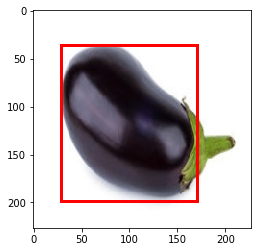

In [8]:
#original
ind = 91
im = cv2.imread(tbl.loc[ind]['image'])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_bb(im, np.array(tbl.loc[ind][['xmin', 'ymin', 'xmax', 'ymax']].tolist()))

['29' '36' '171' '198']
[29, 36, 170, 197]


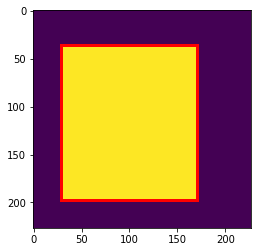

In [9]:
bb = np.array(tbl.loc[ind][['xmin', 'ymin', 'xmax', 'ymax']])
print(bb)
Y = create_mask(bb, im)
#XX, YY = random_cropXY(im, Y)
bbb = mask_to_bb(Y)
print (bbb)
show_bb(Y, bbb)
#show_bb(im, bbb)

[26, 51, 199, 203]


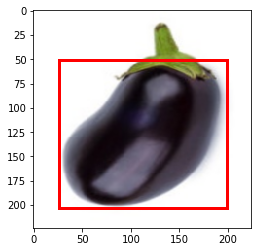

In [10]:
im, bb = transformsXY(tbl.loc[ind]['image'], np.array(tbl.loc[ind][['xmin', 'ymin', 'xmax', 'ymax']].tolist()),True, 224, 224 )
print(bb)
show_bb(im, bb)

## **use data agumentation before training and save it**

In [11]:
data = defaultdict(list)
multiplex = 6
new_base = "./vege"
for index, row in tbl.iterrows():
    im, bb = transformsXY(row['image'], np.array(row[['xmin', 'ymin', 'xmax', 'ymax']].tolist()),
                          False, xsize, ysize)

    base = os.path.basename(row['image'])
    fname, ext = os.path.splitext(base)
    data["image"].append(os.path.join(new_base, "%s%s"%(fname, ext)))
    data["bb"].append([int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])])
    data["class"].append(image_map[row['target']])
    cv2.imwrite(os.path.join(new_base, "%s%s"%(fname, ext)), cv2.cvtColor(im*255, cv2.COLOR_RGB2BGR))
    for cl in range(multiplex):
        im, bb = transformsXY(row['image'], np.array(row[['xmin', 'ymin', 'xmax', 'ymax']].tolist()),
                             True, xsize, ysize)
        data["image"].append(os.path.join(new_base, "%s_%s%s"%(fname, cl, ext)))
        data["bb"].append(bb)
        data["class"].append(image_map[row['target']])
        cv2.imwrite(os.path.join(new_base, "%s_%s%s"%(fname, cl, ext)), cv2.cvtColor(im*255, cv2.COLOR_RGB2BGR))   
    
ftbl = pd.DataFrame(data)  
ftbl.head()
        
        

,image,bb,class
0,./vege/cucumber_29.jpg,"[14, 97, 214, 184]",0
1,./vege/cucumber_29_0.jpg,"[11, 39, 222, 141]",0
2,./vege/cucumber_29_1.jpg,"[7, 85, 218, 185]",0
3,./vege/cucumber_29_2.jpg,"[90, 9, 193, 220]",0
4,./vege/cucumber_29_3.jpg,"[9, 89, 217, 183]",0


In [12]:
class MyDataSet(Dataset):
    def __init__(self, path, target, bb):
        super(MyDataSet, self).__init__()   
        self.path = path
        self.target = target
        self.bb = bb
        
    def __getitem__(self, index):
        im = cv2.imread(self.path[index])
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = normalize(im)
        im = np.rollaxis(im, 2)
        target = self.target[index]
        bb = self.bb[index]
        return im.astype(float), target, np.array(normalize_bbox(bb))
    
    def __len__(self):
        return len(self.target)

In [13]:
images = ftbl["image"].values.tolist()
targets = ftbl["class"].values.tolist()
bbs = ftbl["bb"].values.tolist()

In [14]:
#train data set
ratio = 0.9
totalN = len(targets)
#np.random.seed(100)
rand_index = np.random.permutation(range(totalN))
train_index = rand_index[0:int(totalN*ratio)]
valid_index = rand_index[int(totalN*ratio):]
images_train = [images[i] for i in train_index]
targets_train = [targets[i] for i in train_index]
bbs_train = [bbs[i] for i in train_index]
images_valid = [images[i] for i in valid_index]
targets_valid = [targets[i] for i in valid_index]
bbs_valid = [bbs[i] for i in valid_index]

In [15]:
#print(images[0:5])
#print(targets[0:5])
#print(bbs[0:5])
#print(images_train[0:5])
#print(targets_train[0:5])
#print(bbs_train[0:5])

In [16]:
ds_train = MyDataSet(images_train, targets_train, bbs_train)
ds_valid = MyDataSet(images_valid, targets_valid, bbs_valid)
print(len(ds_train),len(ds_valid))

1171 131


In [17]:
loader_train = DataLoader(
    ds_train,
    batch_size=17,
    num_workers=20,
    shuffle=False
)
loader_valid = DataLoader(
    ds_valid,
    batch_size=17,
    num_workers=20,
    shuffle=True
)

In [18]:
class BBOX(nn.Module):
    def __init__(self):
        super(BBOX, self).__init__()
        vgg = models.vgg16(pretrained=True)
        #print(vgg)
        self.features = vgg.features
        #print (self.features)
        self.classifier = nn.Sequential(nn.Linear(512, 64), nn.BatchNorm1d(64), nn.Linear(64, 3))
        #print(self.classifier)
        self.bbox = nn.Sequential(nn.Linear(512, 64), nn.BatchNorm1d(64), nn.Linear(64, 4))
        #print(self.bbox)
    
    def forward(self, x):
        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bbox(x)

In [19]:
is_cuda= False
if torch.cuda.is_available():
    is_cuda = True
    model = BBOX().cuda()
else:
    model = BBOX()   
print(is_cuda)  


True


In [20]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [21]:
#ld = iter(loader_train)
#x, y_class, y_bb = ld.next()
#x = x.type(torch.FloatTensor)
#print(model(x.cuda()))


In [22]:
def train_epocs(model, optimizer, train_load, valid_load, epochs=1,C=10):
    for i in range(1, epochs+1):
        
        ## For training
        model.train()
        total = 0
        sum_loss = 0
        correct = 0
        sum_bb_loss = 0
        sum_class_loss = 0
        for x, y_class, y_bb in train_load:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            #print('out_class', out_class)
            #print('y_class', y_class)
            _, pred = torch.max(out_class, 1)
            #print('pred', pred)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            #print('loss_class', loss_class)
            correct += pred.eq(y_class).sum().item()
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()/C
            loss = loss_class + loss_bb
            sum_bb_loss += loss_bb.item()
            sum_class_loss += loss_class.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
            #print("sum_bb_loss", sum_bb_loss)
            #print("sum_class_loss", sum_class_loss)
            #print("sum_loss", sum_loss)
        train_loss = sum_loss/total
        train_acc = correct/total
        train_bb_loss = sum_bb_loss/total
        
        ## For Validation
        model.eval()
        total = 0
        sum_loss = 0
        correct = 0
        sum_bb_loss = 0
        sum_class_loss = 0
        for x, y_class, y_bb in valid_load:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            _, pred = torch.max(out_class, 1)
            correct += pred.eq(y_class).sum().item()
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()/C
            sum_bb_loss += loss_bb.item()
            loss = loss_class + loss_bb
            total += batch
            sum_loss += loss.item()
  
        valid_loss = sum_loss/total     
        valid_acc = correct/total
        valid_bb_loss = sum_bb_loss/total
        if i % 10 == 0:
            torch.save(model.state_dict(), './bbox_%s.pth'%i)
        print()
        
        print("epoc:%s train_loss %.3f  train_acc %.3f train_bb_error: %.3f val_loss %.3f val_acc %.3f valid_bb_error: %.3f " %
              (i, train_loss, train_acc, train_bb_loss, valid_loss, valid_acc, valid_bb_loss ))
                
    return 0

In [23]:
#model = BBOX.cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0001)
    
#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print (name, param.data, param.requires_grad)

In [24]:
train_epocs(model, optimizer, loader_train, loader_valid, epochs=80)


epoc:1 train_loss 0.368  train_acc 0.974 train_bb_error: 0.205 val_loss 0.223 val_acc 1.000 valid_bb_error: 0.193 

epoc:2 train_loss 0.231  train_acc 1.000 train_bb_error: 0.185 val_loss 0.202 val_acc 1.000 valid_bb_error: 0.178 

epoc:3 train_loss 0.208  train_acc 1.000 train_bb_error: 0.176 val_loss 0.192 val_acc 1.000 valid_bb_error: 0.176 

epoc:4 train_loss 0.191  train_acc 1.000 train_bb_error: 0.165 val_loss 0.172 val_acc 1.000 valid_bb_error: 0.161 

epoc:5 train_loss 0.176  train_acc 1.000 train_bb_error: 0.153 val_loss 0.162 val_acc 1.000 valid_bb_error: 0.144 

epoc:6 train_loss 0.159  train_acc 1.000 train_bb_error: 0.139 val_loss 0.139 val_acc 1.000 valid_bb_error: 0.132 

epoc:7 train_loss 0.138  train_acc 1.000 train_bb_error: 0.122 val_loss 0.121 val_acc 1.000 valid_bb_error: 0.113 

epoc:8 train_loss 0.117  train_acc 1.000 train_bb_error: 0.103 val_loss 0.100 val_acc 1.000 valid_bb_error: 0.094 

epoc:9 train_loss 0.095  train_acc 1.000 train_bb_error: 0.084 val_loss

KeyboardInterrupt: 

**Let's Check model output**

In [25]:
loader = iter(loader_valid)

In [26]:
model.load_state_dict(torch.load('./bbox_40.pth'))
model.eval()

BBOX(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [40]:

x, y_class, y_bb = loader.next()
x = x.type(torch.FloatTensor)
pred, bbox = model(x.cuda())
pred_class = torch.max(pred, 1)[1].detach().cpu().numpy()
y_class = y_class.numpy()
bbox = bbox.detach().cpu().numpy()
for label, pred in zip(y_class, pred_class):
    print("Label: %s  Prediction: %s" % (index_image[label], index_image[pred]))

Label: cucumber  Prediction: cucumber
Label: eggplant  Prediction: eggplant
Label: cucumber  Prediction: cucumber
Label: cucumber  Prediction: cucumber
Label: eggplant  Prediction: eggplant
Label: eggplant  Prediction: eggplant
Label: mushroom  Prediction: mushroom
Label: eggplant  Prediction: eggplant
Label: cucumber  Prediction: cucumber
Label: cucumber  Prediction: cucumber
Label: cucumber  Prediction: cucumber
Label: cucumber  Prediction: cucumber
Label: mushroom  Prediction: mushroom
Label: eggplant  Prediction: eggplant
Label: eggplant  Prediction: eggplant
Label: mushroom  Prediction: mushroom
Label: eggplant  Prediction: eggplant


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Text(0.5, 0.98, 'red: ground truth  yellow: model prediction')

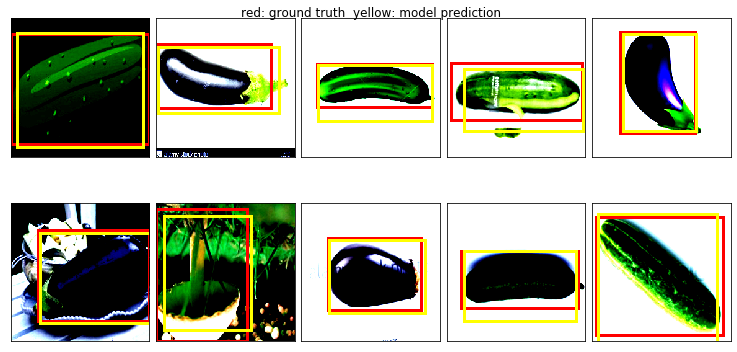

In [41]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(left=0.,right=1,bottom=0,top=1,hspace=0.05,wspace=0.05)
row = 2
col = 5
X = x.numpy().transpose((0,2,3,1))

for i in range(row):
    for j in range(col):
        ind = i*col + j
        ax = fig.add_subplot(row,col,ind+1,xticks=[],yticks=[])
        ax.imshow(X[ind]) 
        plt.gca().add_patch(create_bb(y_bb[ind]*224, 'red'))  
        plt.gca().add_patch(create_bb(bbox[ind]*224, 'yellow'))
fig.suptitle("red: ground truth  yellow: model prediction")   